#### Imports

In [1]:
import pandas as pd
from collections import defaultdict
import re

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Data

In [2]:
int_column_names = ['interval_name', 'interval_begin', 'interval_end', 'keys', 'values']
event_column_names = ['event_id', 'timestamp', 'keys', 'values']

intervals = pd.read_csv('lanl_intervals', sep='|', header=None, names=int_column_names)
events = pd.read_csv('lanl_10k.events', sep='|', header=None, names=event_column_names)

spec_data = defaultdict(list)
with open('lanl.nfer', 'r') as file:
    lines = file.readlines()

for line in lines:
    line = line.strip()
    if ":-" in line:
        interval_name, values = line.split(":-")
        interval_name = interval_name.strip()
        values = values.strip()
        spec_data[interval_name].append(values)
        
unique_intervals = intervals['interval_name'].unique().tolist()


#### Example interval instance

In [97]:
# instance_id = 3        # event
# instance_id = 9        # event vs event
instance_id = 10     #event vs interval
# instance_id = 12     # subrule: event vs interval **special case with two pairs of possibilties

selected_interval = intervals.iloc[instance_id]

interval_name = selected_interval['interval_name']
interval_begin = selected_interval['interval_begin']
interval_end = selected_interval['interval_end']

print(interval_name,interval_begin,interval_end)

sensor_ok 16630406179272 16630407731416


#### Retrieve associated rule

In [98]:
keywords = ['during','before']

# Retrieve the rule associated with the selected interval name
rule = spec_data[interval_name][0]

def split_rule_by_keywords(rule, keywords):
    # Escape the keywords for use in regex and create a pattern that matches any of the keywords
    pattern = '|'.join(re.escape(keyword) for keyword in keywords)
    
    
    # Use regex to find all parts of the rule based on the keywords
    parts = re.split(f'\\s*({pattern})\\s*', rule)
    
    
    # Filter out empty strings and keep the relevant parts
    parts = [part for part in parts if part]
    # To correctly handle nested parts within parentheses, we will keep track of them
    result = []
    current_part = []

    for part in parts:
        if '(' in part:
            current_part.append(part)
        elif ')' in part:
            current_part.append(part)
            # Join all parts within parentheses and add to result
            result.append(' '.join(current_part))
            current_part = []
        elif current_part:
            current_part.append(part)
        else:
            result.append(part)

    return result

# Split the rule using the function
split_rules  = split_rule_by_keywords(rule, keywords)
print('MAIN RULE: ',split_rules)

MAIN RULE:  ['USREVENT_EVENT-12', 'during', 'sensor']


#### Retrieve interval creation DS

In [99]:
import re

# Check if an element is an event
def is_event(element):
    match = re.search(r'USREVENT_EVENT-\d+', element)
    return bool(match), match.group(0) if match else None

# Check if an element is an interval
def is_interval(element):
    # extract the event name from the string
    pattern = r'\b(' + '|'.join(re.escape(interval) for interval in intervals['interval_name'].unique()) + r')\b'
    
    # Search for the interval name in the element
    match = re.search(pattern, element)
    
    if match:
        return True, match.group(1)  # Return flag and interval name
    return False, None

# Retrieve the timestamp for an event
def get_event_timestamps(event_id):
    event_rows = events[events['event_id'] == event_id]
    if not event_rows.empty:
        # Return all timestamps as a list
        return event_rows['timestamp'].tolist()
    else:
        print(f"Event {event_id} not found")
        return []

# Retrieve instances of an interval from the interval dataframe
def get_interval_instances(interval_name):
    return intervals[intervals['interval_name'] == interval_name]



def check_split_rule_for_subrule(rule, keywords):
    # Escape the keywords for use in regex and create a pattern that matches any of the keywords
    pattern = '|'.join(re.escape(keyword) for keyword in keywords)
    
    
    # Use regex to find all parts of the rule based on the keywords
    parts = re.split(f'\\s*({pattern})\\s*', rule)
    
    
    # Filter out empty strings and keep the relevant parts
    parts = [part for part in parts if part]
    if len(parts)>1:
        return parts,1

    return parts,None

def validate_syntax(i1_id, i1_data, i2_data, i2_id, i_start, i_end, syntax,subruleFlag):
    """
    Validate the relationship between i1 and i2 based on the syntax.
    i1_data and i2_data can be either lists of event timestamps or intervals (DataFrames).
    i_start and i_end represent the main interval's start and end, ensuring that the validation respects those bounds.
    """

    valid_instances = []

    # Case 1: Both i1_data and i2_data are lists of event timestamps
    if isinstance(i1_data, list) and isinstance(i2_data, list):  # Both are events
        for i1_time in i1_data:
            for i2_time in i2_data:
                if syntax == 'before':
                    # Event 1 must occur before Event 2, and respect the interval bounds
                    if subruleFlag ==True:
                        if i1_time < i2_time and i1_time>=i_start and i2_time<=i_end:
                            valid_instances.append({
                                'data': [
                                    {
                                        'id': i1_id,
                                        'start': i1_time,
                                        'end': i1_time,
                                        'children': None
                                    },
                                    {
                                        'id': i2_id,
                                        'start': i2_time,
                                        'end': i2_time,
                                        'children': None
                                    }
                                ]})
                    else:
                        if i1_time < i2_time and i_start == i1_time and i_end == i2_time:
                            valid_instances.append({
                                'data': [
                                    {
                                        'id': i1_id,
                                        'start': i1_time,
                                        'end': i1_time,
                                        'children': None
                                    },
                                    {
                                        'id': i2_id,
                                        'start': i2_time,
                                        'end': i2_time,
                                        'children': None
                                    }
                                ]})
                # 'during' does not apply to events
                # Add more syntaxes as needed

    # Case 2: i1_data is a list of event timestamps (events), i2_data is an interval (DataFrame)
    elif isinstance(i1_data, list) and isinstance(i2_data, pd.DataFrame):  # i1 is event, i2 is interval
        new_rule = spec_data[i2_id][0]
        for i1_time in i1_data:
            for _, i2_row in i2_data.iterrows():
                i2_start = i2_row['interval_begin']
                i2_end = i2_row['interval_end']

                if syntax == 'before':
                    # Event must occur before the interval starts and respect interval bounds
                    if i1_time < i2_start and i_start == i1_time and i_end == i2_end:
                        valid_instances.append({
                                'data': [
                                    {
                                        'id': i1_id,
                                        'start': i1_time,
                                        'end': i1_time,
                                        'children': None
                                    },
                                    {
                                        'id': i2_id,
                                        'start': i2_start,
                                        'end': i2_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule, keywords), i2_start, i2_end,subruleFlag=False)
                                    }
                                ]})
                elif syntax == 'during':
                    # Event occurs during the interval, and respect interval bounds
                    if i1_time >= i2_start and i1_time <= i2_end and i_start == i2_start and i_end == i2_end:
                        valid_instances.append({
                                'data': [
                                    {
                                        'id': i1_id,
                                        'start': i1_time,
                                        'end': i1_time,
                                        'children': None
                                    },
                                    {
                                        'id': i2_id,
                                        'start': i2_start,
                                        'end': i2_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule, keywords), i2_start, i2_end,subruleFlag=False)
                                    }
                                ]})

    # Case 3: i1_data is an interval (DataFrame), i2_data is a list of event timestamps (events)
    elif isinstance(i1_data, pd.DataFrame) and isinstance(i2_data, list):  # i1 is interval, i2 is event
        new_rule = spec_data[i1_id][0]
        for _, i1_row in i1_data.iterrows():
            i1_start = i1_row['interval_begin']
            i1_end = i1_row['interval_end']

            for i2_time in i2_data:
                if syntax == 'before':
                    # Interval must end before the event and respect interval bounds
                    if i1_end < i2_time and i_start == i1_start and i_end == i2_time:
                        valid_instances.append({
                                'data': [
                                    {
                                        'id': i1_id,
                                        'start': i1_start,
                                        'end': i1_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule, keywords), i1_start, i1_end,subruleFlag=False)
                                    },
                                    {
                                        'id': i2_id,
                                        'start': i2_time,
                                        'end': i2_time,
                                        'children': None
                                    }
                                ]})
                elif syntax == 'during':
                    # Event occurs during the interval and respect interval bounds
                    if i2_time >= i1_start and i2_time <= i1_end and i_start == i1_start and i_end == i1_end:
                        valid_instances.append({
                                'data': [
                                    {
                                        'id': i1_id,
                                        'start': i1_start,
                                        'end': i1_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule, keywords), i1_start, i1_end,subruleFlag=False)
                                    },
                                    {
                                        'id': i2_id,
                                        'start': i2_time,
                                        'end': i2_time,
                                        'children': None
                                    }
                                ]})

    # Case 4: Both i1_data and i2_data are intervals (DataFrames)
    elif isinstance(i1_data, pd.DataFrame) and isinstance(i2_data, pd.DataFrame):  # Both are intervals
        new_rule_1 = spec_data[i1_id][0]
        new_rule_2 = spec_data[i2_id][0]
        for _, i1_row in i1_data.iterrows():
            i1_start = i1_row['interval_begin']
            i1_end = i1_row['interval_end']

            for _, i2_row in i2_data.iterrows():
                i2_start = i2_row['interval_begin']
                i2_end = i2_row['interval_end']

                if syntax == 'before':
                    # Interval 1 ends before Interval 2 starts, and respect the interval bounds
                    if i1_end < i2_start and i_start == i1_start and i_end == i2_end:
                        valid_instances.append({
                                'data': [
                                    {
                                        'id': i1_id,
                                        'start': i1_start,
                                        'end': i1_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule_1, keywords), i1_start, i1_end,subruleFlag=False)
                                    },
                                    {
                                        'id': i2_id,
                                        'start': i2_start,
                                        'end': i2_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule_2, keywords), i2_start, i2_end,subruleFlag=False)
                                    }
                                ]})
                elif syntax == 'during':
                    # Interval 1 occurs during Interval 2, and respect the interval bounds
                    if i1_start >= i2_start and i1_end <= i2_end and i_start == i2_start and i_end == i2_end:
                        valid_instances.append({
                                'data': [
                                    {
                                        'id': i1_id,
                                        'start': i1_start,
                                        'end': i1_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule_1, keywords), i1_start, i1_end,subruleFlag=False)
                                    },
                                    {
                                        'id': i2_id,
                                        'start': i2_start,
                                        'end': i2_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule_2, keywords), i2_start, i2_end,subruleFlag=False)
                                    }
                                ]})

    return valid_instances if valid_instances else None  # Return valid instances or None

# Process the rule with dynamic assignment of i1 (event) and i2 (event or interval set)
def process_general_rule(final_rule, interval_begin=None, interval_end=None,subruleFlag=False):
    i1, i2, syntax = None, None, None

    print(f"Processing rule: {final_rule}")
    sub_result=None
    for element in final_rule:
        # Check if the element is an event
        if check_split_rule_for_subrule(element,keywords)[1]:
            "---Processing Sub Rule---"
            
            subruleFlag=True
            sub_rule=check_split_rule_for_subrule(element,keywords)[0]
            sub_result = process_general_rule(sub_rule, interval_begin, interval_end,subruleFlag)
            subruleFlag=False          
        else:
            is_event_result, event_id = is_event(element)
            
            if is_event_result:
                # Process the event and retrieve all occurrences (timestamps)
                
                event_timestamps = get_event_timestamps(event_id)

                if not event_timestamps:
                    return None  # Event not found

                if len(final_rule)==1:
                    valid_event_instances = []
                    for event_timestamp in event_timestamps:
                        if event_timestamp >= interval_begin and event_timestamp <= interval_end:
                            valid_event_instances.append(event_timestamp)
                    return [{'data': {'id': event_id,
                                        'start': ts,
                                        'end': ts,
                                        'children': None
                                    }}for ts in valid_event_instances]
                # Assign to i1 or i2 depending on whether i1 is already assigned
                if i1 is None:
                    i1 = (event_id, event_timestamps)  # Store event_id and all timestamps for i1
                else:
                    i2 = (event_id, event_timestamps)  # Store event_id and all timestamps for i2


            elif is_interval(element)[0]:
                # Process the interval\
                name = is_interval(element)[1]
                interval_instances = get_interval_instances(name)
                new_rule = spec_data[name][0]
                if interval_instances.empty:
                    return None  # No valid interval instances found
                if sub_result is not None:
                    sub_result.append({
                                'data': [
                                    {
                                        'id': name,
                                        'start': interval_begin,
                                        'end': interval_end,
                                        'children': process_general_rule(split_rule_by_keywords(new_rule, keywords), interval_begin, interval_end,subruleFlag=False)
                                    }
                                ]})
                    
                    return sub_result

                if i1 is None:
                    i1 = (element, interval_instances)
                else:
                    i2 = (element, interval_instances)
            else:
                syntax = element

            # When both i1, i2, and syntax are available, we validate the rule
            if i1 and i2 and syntax:
                i1_id, i1_data = i1
                i2_id, i2_data = i2
               

                # Handle the validation logic (event vs event, interval vs interval, or mixed)
                valid_instances = validate_syntax(i1_id, i1_data, i2_data, i2_id, interval_begin, interval_end, syntax,subruleFlag)
                if valid_instances:
                    return valid_instances  # Return the valid instances with IDs
                else:
                    print("No valid instances found")
                    return None  # Syntax validation failed

    return None

print("INTERVAL NAME:{},INTERVAL BEGIN:{},INTERVAL END:{}".format(interval_name,interval_begin, interval_end))
print("ASSOCIATED RULE:{}".format(split_rules))
print("EVENT AND INTERVAL RESPONSIBLE:")
valid_event_data = process_general_rule(split_rules, interval_begin, interval_end,subruleFlag=False)

for data in valid_event_data:
    print(data)
    print('\n')

# # while True:
# found_interval = False
# new_data = []    
# for data in valid_event_data:
#     try:
#         i1_id = data['i1']['id']
#         if i1_id in unique_intervals:

#             new_rule = spec_data[i1_id][0]
#             new_result = process_general_rule(split_rule_by_keywords(new_rule, keywords), data['i1']['start'], data['i1']['end'])
#             if new_result:
#                 data['i1']= new_result
#                 found_interval = True
#     except:
#         print('NO I1')
        
#     try:
#         i2_id = data['i2']['id']



#         if i2_id in unique_intervals:

#             new_rule = spec_data[i2_id][0]

#             new_result = process_general_rule(split_rule_by_keywords(new_rule, keywords), data['i2']['start'], data['i2']['end'])
#             if new_result:
 
#                 data['i2'] = new_result
#                 found_interval = True
#     except:
#         print('NO I2')

# print(valid_event_data)


INTERVAL NAME:sensor_ok,INTERVAL BEGIN:16630406179272,INTERVAL END:16630407731416
ASSOCIATED RULE:['USREVENT_EVENT-12', 'during', 'sensor']
EVENT AND INTERVAL RESPONSIBLE:
Processing rule: ['USREVENT_EVENT-12', 'during', 'sensor']
Processing rule: ['USREVENT_EVENT-20', 'before', 'USREVENT_EVENT-21']
{'data': [{'id': 'USREVENT_EVENT-12', 'start': 16630407719437, 'end': 16630407719437, 'children': None}, {'id': 'sensor', 'start': 16630406179272, 'end': 16630407731416, 'children': [{'data': [{'id': 'USREVENT_EVENT-20', 'start': 16630406179272, 'end': 16630406179272, 'children': None}, {'id': 'USREVENT_EVENT-21', 'start': 16630407731416, 'end': 16630407731416, 'children': None}]}]}]}




In [14]:
df1 = events[(events.event_id=='USREVENT_EVENT-8')]

df2 = events[(events.event_id=='USREVENT_EVENT-10')]

In [15]:
df1[df1.timestamp>=16630407242086]

,event_id,timestamp,keys,values
15,USREVENT_EVENT-8,16630407244374,pid,0x0000b01a
17,USREVENT_EVENT-8,16630407325759,pid,0x0000b019
28,USREVENT_EVENT-8,16630419517401,pid,0x0000b018
32,USREVENT_EVENT-8,16630419724515,pid,0x0000b01a
34,USREVENT_EVENT-8,16630419773629,pid,0x0000b019
...,...,...,...,...
9936,USREVENT_EVENT-8,16635465774173,pid,0x0000b019
9963,USREVENT_EVENT-8,16635477594460,pid,0x0000b01a
9965,USREVENT_EVENT-8,16635477793945,pid,0x0000b018
9967,USREVENT_EVENT-8,16635478195954,pid,0x0000b019


In [16]:
df2[df2.timestamp<=16630407795002]

,event_id,timestamp,keys,values
18,USREVENT_EVENT-10,16630407642906,pid,0x0000b018
22,USREVENT_EVENT-10,16630407793170,pid,0x0000b01a


In [18]:
for t1 in df1[df1.timestamp>=16630407242086].timestamp:
    for t2 in df2[df2.timestamp<=16630407795002].timestamp:
        if(t1<t2):
            print(t1,t2)

16630407244374 16630407642906
16630407244374 16630407793170
16630407325759 16630407642906
16630407325759 16630407793170


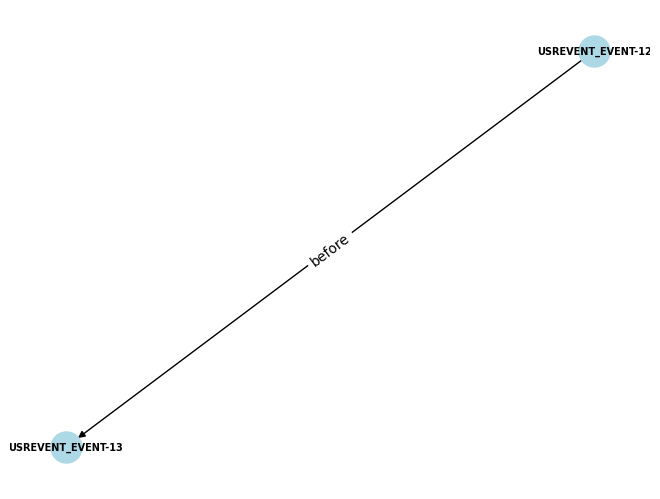

In [105]:
import networkx as nx
import matplotlib.pyplot as plt

# Data structure, simplified for illustration
events = [
    {
        'id': 'USREVENT_EVENT-12', 
        'start': 123456, 
        'end': 123456, 
        'relationship': 'before',  # Relationship
        'children': None
    },
    {
        'id': 'USREVENT_EVENT-13', 
        'start': 654321, 
        'end': 654321,  
        'children': None
    }
]

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes to the graph (for each event)
for event in events:
    G.add_node(event['id'], start=event['start'], end=event['end'])

# Add an edge between i1 and i2 based on the 'relationship' field
i1 = events[0]['id']
i2 = events[1]['id']
relationship = events[0]['relationship']  # Assuming 'before' is stored with i1
G.add_edge(i1, i2, relationship=relationship)

# Draw the graph
pos = nx.spring_layout(G)  # Use spring layout for better node spacing
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=7, font_weight='bold')

# Draw edge labels (i.e., the relationship like 'before')
edge_labels = nx.get_edge_attributes(G, 'relationship')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the graph
plt.show()
